# Genetic Optimization (GO)

__all parameters are chosen randomly__

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
# Import external libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 

In [3]:
# initialization
from objfun_node2vec import N2V
n2v = N2V('../data/clear_cluster_test/one_eighth.csv',
            '../data/clear_cluster_test/labels.csv')

In [4]:
num_params = 5
# Defining the population size.
sol_per_pop = 8
parents_num = 4
# The population will have sol_per_pop chromosome where each chromosome has num_weights num_params.
pop_size = (sol_per_pop, num_params)

## 1. An example experiment
1. At the example experiment a new population consisting of 8 solutions was created. 

In [5]:
# randomly sets parameters values for a
def create_population():
    population = np.zeros(shape=pop_size)
    for individ in population:
        individ[0] = np.random.uniform(low=0.125, high=4.125)
        individ[1] = np.random.uniform(low=0.125, high=4.125)
        individ[2] = np.random.randint(4,32)
        individ[3] = np.random.randint(32,128)
        individ[4] = np.random.randint(2,32)
    return population

In [6]:
new_population = create_population()
print(new_population)

[[  2.61102083   2.7156483   18.          34.           6.        ]
 [  1.51307311   2.30455123  15.         103.          27.        ]
 [  1.15581161   1.21181799   9.         122.          21.        ]
 [  3.8140496    0.14590533   5.          84.          22.        ]
 [  2.85703174   3.07848309  12.          50.           2.        ]
 [  1.43950531   0.61115547  15.          50.           6.        ]
 [  3.06012595   1.71530819  19.          50.          19.        ]
 [  2.1166793    0.90017019  29.         120.           8.        ]]


In [7]:
def fitness_calc(new_population):
    fitness = []
    for ind in new_population:
        fitness.append(n2v.evaluate(p=ind[0],q=ind[1],num_walks=int(ind[2]),len_walks=int(ind[3]),
                                    window=int(ind[4])))
    return fitness

fitness = fitness_calc(new_population)
print(fitness)

[0.6744186046511628, 0.8928571428571429, 0.8928571428571429, 0.052083333333333336, 0.3133802816901408, 0.19318181818181818, 1.0, 0.7976190476190477]


In [8]:
def select_parents(new_population, fitness, parents_num):
    parents = np.empty((parents_num, new_population.shape[1]))
    for num in range(parents_num):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[num, :] = new_population[max_fitness_idx, :]
        fitness[max_fitness_idx] = 0
    return parents

parents = select_parents(new_population, fitness, parents_num)
print(parents)

[[  3.06012595   1.71530819  19.          50.          19.        ]
 [  1.51307311   2.30455123  15.         103.          27.        ]
 [  1.15581161   1.21181799   9.         122.          21.        ]
 [  2.1166793    0.90017019  29.         120.           8.        ]]


In [9]:
# 1-point crossover (1/2)
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Here, it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

# Generating next generation using crossover.
offspring_crossover = crossover(parents,
                                    offspring_size=(pop_size[0]-parents.shape[0], num_params))
print(offspring_crossover)

[[  3.06012595   1.71530819  15.         103.          27.        ]
 [  1.51307311   2.30455123   9.         122.          21.        ]
 [  1.15581161   1.21181799  29.         120.           8.        ]
 [  2.1166793    0.90017019  19.          50.          19.        ]]


In [10]:
def mutation(offspring_crossover, num_mutations=1):
    mutations_counter = np.uint8(offspring_crossover.shape[1] / num_mutations)
    # Mutation changes a number of genes as defined by the num_mutations argument. The changes are random.
    for idx in range(offspring_crossover.shape[0]):
        gene_idx = np.random.randint(0,4)
        for mutation_num in range(num_mutations):
            # The random value to be added to the gene.
            if gene_idx == 0 or gene_idx == 1:
                random_value = np.random.uniform(-0.1, 1.0, 1)
                offspring_crossover[idx, gene_idx] = offspring_crossover[idx, gene_idx] + random_value
            elif gene_idx == 2 or gene_idx == 3 or gene_idx == 4:
                random_value = np.random.randint(-10, 10, 1)
                offspring_crossover[idx, gene_idx] = offspring_crossover[idx, gene_idx] + random_value
            gene_idx = gene_idx + mutations_counter
    return offspring_crossover

# Adding some variations to the offsrping using mutation.
offspring_mutation = mutation(offspring_crossover)
print(offspring_mutation)

[[  3.06012595   1.71530819  15.          99.          27.        ]
 [  1.51307311   2.30455123   4.         122.          21.        ]
 [  1.15581161   1.36433927  29.         120.           8.        ]
 [  2.1166793    1.8641051   19.          50.          19.        ]]


In [11]:
# Creating the new population based on the parents and offspring.
new_population[0:parents.shape[0], :] = parents
new_population[parents.shape[0]:, :] = offspring_mutation

In [12]:
print(new_population)

[[  3.06012595   1.71530819  19.          50.          19.        ]
 [  1.51307311   2.30455123  15.         103.          27.        ]
 [  1.15581161   1.21181799   9.         122.          21.        ]
 [  2.1166793    0.90017019  29.         120.           8.        ]
 [  3.06012595   1.71530819  15.          99.          27.        ]
 [  1.51307311   2.30455123   4.         122.          21.        ]
 [  1.15581161   1.36433927  29.         120.           8.        ]
 [  2.1166793    1.8641051   19.          50.          19.        ]]


__Demonstration of the algorithm__

In [13]:
new_population = create_population()
print(new_population)

[[  1.65392317   0.49516351  24.          92.          28.        ]
 [  0.46779149   0.30233548  17.          36.          31.        ]
 [  0.50760637   2.42762192  16.          81.          21.        ]
 [  0.29079367   0.70855595  31.          60.          28.        ]
 [  2.51999425   1.15415328   7.          51.          18.        ]
 [  3.93925415   3.23435317  16.         120.          17.        ]
 [  3.27535392   2.38793985  24.          32.          14.        ]
 [  3.4397867    2.41859715  23.          61.          11.        ]]


In [14]:
print(fitness_calc(new_population))

[0.42748091603053434, -0.05434782608695652, 0.7874015748031497, 0.7201492537313433, 0.10661764705882354, 0.813953488372093, 0.48863636363636365, 0.7874015748031497]


In [15]:
num_generations = 4

for generation in range(num_generations):
    print("Generation : ", generation)

    # Measing the fitness of each chromosome in the population.
    fitness = fitness_calc(new_population)

    # Selecting the best parents in the population for mating.
    parents = select_parents(new_population, fitness, 
                                      parents_num)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents,
                                       offspring_size=(pop_size[0]-parents.shape[0], num_params))

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

    # The fitness of the population in the current iteration.
    print(fitness_calc(new_population))

Generation :  0
[0.813953488372093, 0.7874015748031497, 0.7874015748031497, 0.7201492537313433, 1.0, 0.7874015748031497, 1.0, 0.6091549295774648]
Generation :  1
[1.0, 1.0, 0.813953488372093, 0.7874015748031497, 1.0, 0.77734375, 0.68359375, 1.0]
Generation :  2
[1.0, 1.0, 1.0, 1.0, 0.7874015748031497, 0.7874015748031497, 0.8928571428571429, 1.0]
Generation :  3
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7386363636363636, 0.7874015748031497]


__Experiment run__

In [16]:
from heur_go import GeneticOptimization

In [17]:
NUM_RUNS = 30 #1000
maxeval = 10 #1000

In [18]:
# traditional testing procedure setup
def experiment_go(of, maxeval, num_runs, N):
    results = []
    heur_name = 'GO_{}'.format(N)
    for i in tqdm(range(num_runs), 'Testing {}'.format(heur_name)):
        result = GeneticOptimization(of, maxeval, N=N).search()
        result['run'] = i
        result['heur'] = heur_name
        result['N'] = N
        results.append(result)
    return pd.DataFrame(results, columns=['heur', 'run', 'N', 'best_x', 'best_y', 'neval'])

In [19]:
results = pd.DataFrame()
for N in [2,4,8,10,12]:
    res = experiment_go(of=n2v, maxeval=maxeval, num_runs=NUM_RUNS, N=N)
    results = pd.concat([results, res], axis=0)

In [20]:
results

heur  run   N                                             best_x  \
0    GO_2    0   2  [0.7829919263680019, 2.275924139000068, 11.0, ...   
1    GO_2    1   2  [3.91076014393949, 3.5106874676077426, 20.0, 6...   
2    GO_2    2   2  [3.719420121687185, 3.0957516073767146, 29.0, ...   
3    GO_2    3   2  [3.2000994601017667, 3.2838432015574197, 22.0,...   
4    GO_2    4   2  [0.25880408900073837, 0.5664305580547122, 25.0...   
..    ...  ...  ..                                                ...   
25  GO_12   25  12  [2.0554668074185347, 2.906700994291682, 15.0, ...   
26  GO_12   26  12  [1.0495305242150814, 3.7258031319382154, 24.0,...   
27  GO_12   27  12  [0.47177406118938103, 3.984551156805292, 18.0,...   
28  GO_12   28  12  [1.7920039429395236, 2.9485994168426353, 31.0,...   
29  GO_12   29  12  [0.7546330863624675, 2.7971263589590296, 15.0,...   

      best_y  neval  
0   0.744681    inf  
1   1.000000    2.0  
2   1.000000    4.0  
3   0.892857    inf  
4   0.892857    inf  
..       ...    ...  
25  1.000000    1.0  
26  1.000000    1.0  
27  1.000000    1.0  
28  1.000000    1.0  
29  1.000000    1.0  

[150 rows x 6 columns]

In [21]:
# import visualization libraries
import matplotlib
# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

__Number of evaluations (when successful), based on N?__

In [22]:
results['success'] = results['neval'] < np.inf

In [23]:
results[results['success'] == True].head()

heur  run  N                                             best_x  best_y  \
1  GO_2    1  2  [3.91076014393949, 3.5106874676077426, 20.0, 6...     1.0   
2  GO_2    2  2  [3.719420121687185, 3.0957516073767146, 29.0, ...     1.0   
5  GO_2    5  2  [2.093211643151771, 2.618295225788088, 23.0, 1...     1.0   
7  GO_2    7  2  [1.0347025959462575, 0.8134646034453183, 25.0,...     1.0   
8  GO_2    8  2  [2.1951723999295525, 3.4880698554294836, 20.0,...     1.0   

   neval  success  
1    2.0     True  
2    4.0     True  
5    2.0     True  
7    1.0     True  
8    1.0     True

In [24]:
results[results['success'] == True].groupby(['N'])['neval'].mean()

N
2     2.954545
4     1.730769
8     1.666667
10    1.000000
12    1.000000
Name: neval, dtype: float64

In [25]:
results[results['success'] == True].groupby(['N'])['neval'].median()

N
2     1.0
4     1.0
8     1.0
10    1.0
12    1.0
Name: neval, dtype: float64

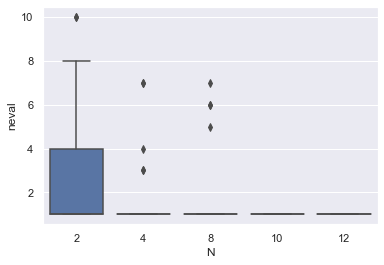

In [26]:
ax2 = sns.boxplot(x="N", y="neval", data=results[results['success'] == True])

In [27]:
# performance criteria
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)
def mne(x):
    return np.mean([n for n in x if n < np.inf])
def feo(x):
    return mne(x)/rel(x)

In [28]:
results_pivot = results.pivot_table(
    index=['heur', 'N'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot = results_pivot.reset_index()
results_pivot.sort_values(by='N')

heur   N       feo       mne       rel
2   GO_2   2  4.028926  2.954545  0.733333
3   GO_4   4  1.997041  1.730769  0.866667
4   GO_8   8  1.666667  1.666667  1.000000
0  GO_10  10  1.000000  1.000000  1.000000
1  GO_12  12  1.000000  1.000000  1.000000

## Conclusion